# EE 782: Advanced Machine Learning
### Assignment 2
Shreyas Patil  
200260052

### **Objectives**

#### Question 1.

In [ ]:
# change directory to the folder you want to download the dataset to
%cd drive/MyDrive/EE782/Assignment\ 2

/content/drive/MyDrive/EE782/Assignment 2


In [ ]:
# download the dataset tgz file
!wget "http://vis-www.cs.umass.edu/lfw/lfw.tgz"

--2023-10-21 12:04:59--  http://vis-www.cs.umass.edu/lfw/lfw.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180566744 (172M) [application/x-gzip]
Saving to: ‘lfw.tgz’

lfw.tgz             100%[===================>] 172.20M  2.32MB/s    in 1m 40s  

2023-10-21 12:06:39 (1.72 MB/s) - ‘lfw.tgz’ saved [180566744/180566744]



In [ ]:
# unzip the dataset
!tar -xzf lfw.tgz

In [ ]:
%ls

lfw/  lfw.tgz


### **Part A**

In [3]:
import os
from tqdm import tqdm

import cv2 as cv #OpenCV
from PIL import Image #Image from PIL

# import basic libraries
import numpy as np
import itertools
from itertools import combinations
import random

import torch
from torchvision.transforms import v2

In [2]:
lfw_processed = os.listdir('lfw_processed')

#### 5.

In [35]:
# earlier defined in #2
x

'lfw\\Abdullah_Gul'

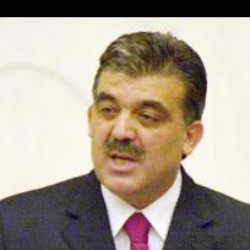

In [37]:
# visualize a few images
Image.open(os.path.join(x, os.listdir(x)[0]))

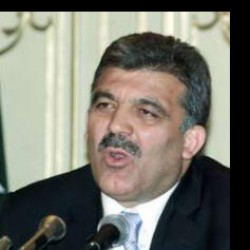

In [244]:
Image.open(os.path.join(x, os.listdir(x)[-1]))

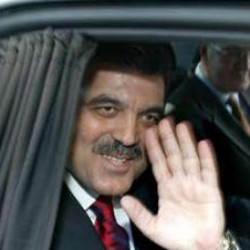

In [246]:
Image.open(os.path.join(x, os.listdir(x)[2]))

The above person was selected randomly by me earlier, and as we can see from the three images of him above, the images clearly have a lot of pixels that do not correspond to the face of the person, and are useless in terms of facial recognition.

This is true for other persons' images as well in the dataset. This is not good for training a face recognition Siamese Network. We need to crop the images to contain mostly the face itself, and not the surroundings.

We will also have to resize the images since the ResNet18 achitecture takes input of square images with dimensions being a multiple 32, upto 256. The best crop size I thus found to work best is 96x96, and the size is maintained the same. This also reduces some computational load in the CNN.

The below block of code is a modified version of the code obtained from https://stackoverflow.com/a/13243712

It detects faces and autocrops them from their images.

Since it is an outdated code created using cv library, I used ChatGPT to convert it and debug the code blocks, along with a few of the below stackoverflow threads:

https://stackoverflow.com/questions/67120966/class-cv2-cascadeclassifier-returned-a-result-with-an-error-set

In [14]:
def DetectFace(image, faceCascade):
    # This function takes a grayscale cv2 image and finds
    # the patterns defined in the haarcascade function
    # Modified from: http://www.lucaamore.com/?p=638

    # Variables
    min_size = (20, 20)
    scaleFactor = 1.1
    minNeighbors = 3
    flags = 0

    # Equalize the histogram
    image = cv.equalizeHist(image)

    # Detect the faces
    faces = faceCascade.detectMultiScale(
        image,
        scaleFactor=scaleFactor,
        minNeighbors=minNeighbors,
        minSize=min_size,
        flags=flags
    )

    return faces

def pil2cvGrey(pil_im):
    # Convert a PIL image to a grayscale cv2 image
    pil_im = pil_im.convert('L')
    cv_im = np.array(pil_im, dtype=np.uint8)
    return cv_im

def imgCrop(image, cropBox):
    # Crop a PIL image with the provided box [x(left), y(upper), w(width), h(height)]

    # Rescale to 96x96
    delta_x = 96 - cropBox[2] if cropBox[2] < 96 else 94 - cropBox[2]
    x1 = cropBox[0] - int(delta_x/2)
    x2 = cropBox[0] + int(delta_x/2) + (delta_x % 2)

    delta_y = 96 - cropBox[3] if cropBox[3] < 96 else 94 - cropBox[3]
    y1 = cropBox[1] - int(delta_y/2)
    y2 = cropBox[1] + int(delta_y/2) + (delta_y % 2)

    # Convert cv2 box to PIL box [left, upper, right, lower]
    PIL_box = [
        x1,
        y1,
        x2 + cropBox[2],
        y2 + cropBox[3]
    ]

    return image.crop(PIL_box)

In [16]:
# a function that takes the image loc as input and returns cropped image
# will be useful while creating dataset

def get_cropped_image(img_path):

  pil_im = Image.open(img_path)                                     # open the image
  cv_im = pil2cvGrey(pil_im)                                        # convert to grayscale
  faceCascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_alt.xml')   # define haarcascade
  face_im = DetectFace(cv_im, faceCascade)                          # detect face
  img = imgCrop(pil_im, face_im[0])                                 # crop image

  return img

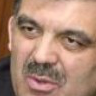

(96, 96)


In [18]:
# Example of cropping the face out using the above defined functions
img = get_cropped_image('lfw/Abdullah_Gul/Abdullah_Gul_0007.jpg')
display(img)
print(img.size)

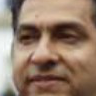

(96, 96)


In [20]:
# Example of cropping the face out using the above defined functions
img = get_cropped_image('lfw/Lucio_Gutierrez/Lucio_Gutierrez_0010.jpg')
display(img)
print(img.size)

Now we create custom data transforms and dataloaders

In [38]:
def process_img_dataset(lfw):

  os.mkdir('lfw_processed')
  for person in tqdm(lfw):
    imgs = os.listdir(os.path.join('lfw', person))
    for img in imgs:
      try:
        im_path = os.path.join('lfw', person, img)
        img_processed = get_cropped_image(im_path)
        save_path = os.path.join('lfw_processed', person, img)
        if not os.path.exists(os.path.join('lfw_processed', person)):
          os.mkdir(os.path.join('lfw_processed', person))
        img_processed.save(save_path)
      except IndexError:
        continue
  return

In [42]:
process_img_dataset(lfw)

100%|██████████████████████████████████████████████████████████████████████████████| 5749/5749 [06:43<00:00, 14.26it/s]


#### Question 2.

In [132]:
x = os.path.join('lfw', 'Abdullah_Gul')
print(os.listdir(x))

['Abdullah_Gul_0001.jpg', 'Abdullah_Gul_0002.jpg', 'Abdullah_Gul_0003.jpg', 'Abdullah_Gul_0004.jpg', 'Abdullah_Gul_0005.jpg', 'Abdullah_Gul_0006.jpg', 'Abdullah_Gul_0007.jpg', 'Abdullah_Gul_0008.jpg', 'Abdullah_Gul_0009.jpg', 'Abdullah_Gul_0010.jpg', 'Abdullah_Gul_0011.jpg', 'Abdullah_Gul_0012.jpg', 'Abdullah_Gul_0013.jpg', 'Abdullah_Gul_0014.jpg', 'Abdullah_Gul_0015.jpg', 'Abdullah_Gul_0016.jpg', 'Abdullah_Gul_0017.jpg', 'Abdullah_Gul_0018.jpg', 'Abdullah_Gul_0019.jpg']


In [179]:
# list of names with more than one image
valid_names = []

# list of names with only one image
invalid_names = []

for name in tqdm(lfw_processed):
  if len(os.listdir(os.path.join('lfw_processed', name))) > 1:
    valid_names.append(name)
  else:
    invalid_names.append(name)

print("The number of persons with more than one image is", len(valid_names))
print("The total number of persons is", len(valid_names)+len(invalid_names))

100%|███████████████████████████████████████████████████████████████████████████| 5514/5514 [00:00<00:00, 10667.86it/s]


The number of persons with more than one image is 1571
The total number of persons is 5514


#### 3. Splitting the Data

The names in the train, val, and test lists below will be our anchor list. We will perform regular siamese network training. We need to ensure that there are roughly equal number of positive and negative pairs of images

In [5]:
valid_names = []
invalid_names = []

for name in tqdm(lfw_processed):
  if len(os.listdir(os.path.join('lfw_processed', name))) > 1:
    valid_names.append(name)
  else:
    invalid_names.append(name)

100%|███████████████████████████████████████████████████████████████████████████| 5514/5514 [00:00<00:00, 16963.25it/s]


In [27]:
images_dict = {'train': {}, 'val': {}, 'test': {}}
for set in images_dict:
  images_dict[set] = {'valid': {}, 'invalid': {}, 'all':{}}
for name in valid_names:
  p = np.random.rand()
  if p < 0.8:
    images_dict['train']['valid'][name] = os.listdir('lfw_processed/' + name)
    images_dict['train']['all'][name] = os.listdir('lfw_processed/' + name)
  elif p < 0.9:
    images_dict['val']['valid'][name] = os.listdir('lfw_processed/' + name)
    images_dict['val']['all'][name] = os.listdir('lfw_processed/' + name)
  else:
    images_dict['test']['valid'][name] = os.listdir('lfw_processed/' + name)
    images_dict['test']['all'][name] = os.listdir('lfw_processed/' + name)

for name in invalid_names:
  p = np.random.rand()
  if p < 0.8:
    images_dict['train']['invalid'][name] = os.listdir('lfw_processed/' + name)
    images_dict['train']['all'][name] = os.listdir('lfw_processed/' + name)
  elif p < 0.9:
    images_dict['val']['invalid'][name] = os.listdir('lfw_processed/' + name)
    images_dict['val']['all'][name] = os.listdir('lfw_processed/' + name)
  else:
    images_dict['test']['invalid'][name] = os.listdir('lfw_processed/' + name)
    images_dict['test']['all'][name] = os.listdir('lfw_processed/' + name)

In [29]:
all_name_comb = {}
for set in images_dict:
  all_name_comb[set] = list(combinations(images_dict[set]['all'], 2))

cross_pairs = {'train': [], 'val': [], 'test': []}
for set in images_dict:
  for comb in tqdm(all_name_comb[set]):
    cross_pairs[set] += list(itertools.product(images_dict[set]['all'][comb[0]], images_dict[set]['all'][comb[1]]))

100%|██████████████████████████████████████████████████████████████████████| 155961/155961 [00:00<00:00, 923912.84it/s]


In [31]:
print(len(cross_pairs['train']), len(cross_pairs['val']), len(cross_pairs['test']))

52073773 611007 529702


In [33]:
all_pairs = {}
for set in images_dict:
  all_pairs[set] = {'pos': [], 'neg':[]}

for set in images_dict:
  for name in tqdm(images_dict[set]['valid']):

    folder = os.path.join('lfw_processed', name)
    images = os.listdir(folder)

    # ref for combinations: https://blog.enterprisedna.co/how-to-generate-all-combinations-of-a-list-in-python/
    pos_image_combinations = list(combinations(images, 2))
    for comb in pos_image_combinations:
      all_pairs[set]['pos'].append([name, comb[0], name, comb[1], 1])

  _cross_pairs = random.choices(cross_pairs[set], k = len(all_pairs[set]['pos']))

  for pair in tqdm(_cross_pairs):
    _ = pair[0].split('_')
    _.pop()
    name_0 = '_'.join(_)
    _ = pair[1].split('_')
    _.pop()
    name_1 = '_'.join(_)
    all_pairs[set]['neg'].append([name_0, pair[0], name_1, pair[1], 0])

100%|██████████████████████████████████████████████████████████████████████████| 2294/2294 [00:00<00:00, 481471.85it/s]


In [35]:
dataset = {"train": [], "val": [], "test": []}
# Dataset[set] element format is a list [name_1, image_1, name_2, image_2, truth value = 1 or 0]

for set in dataset:
  for polarity in all_pairs[set]:
    for pair in tqdm(all_pairs[set][polarity]):
      dataset[set].append(pair)

for _set in dataset:
  random.shuffle(dataset[_set])
  print(f"Number of pairs of images in {_set} = {len(dataset[_set])}")

100%|██████████████████████████████████████████████████████████████████████████████████████| 2294/2294 [00:00<?, ?it/s]


Number of pairs of images in train = 392854
Number of pairs of images in val = 22326
Number of pairs of images in test = 4588


In [37]:
# check random points in the dataset
print(dataset["train"][16378])
print(dataset["val"][5960])
print(dataset["test"][3234])

['Liam_Neeson', 'Liam_Neeson_0002.jpg', 'Klaus_Schwab', 'Klaus_Schwab_0001.jpg', 0]
['Tony_Blair', 'Tony_Blair_0078.jpg', 'Tony_Blair', 'Tony_Blair_0093.jpg', 1]
['Norodom_Sihanouk', 'Norodom_Sihanouk_0002.jpg', 'Lucio_Angulo', 'Lucio_Angulo_0001.jpg', 0]


In [39]:
del cross_pairs
del images_dict

In [41]:
torch.save(dataset, 'img_names_dataset_new2')

We have obtained a balanced split dataset of positive-negative pairs, in about the train:val:test ratio of 70:15:15. We are good to proceed ahead from here.

#### Dataset and DataLoader

In [5]:
import torch
from torch.utils.data import DataLoader, Dataset

In [7]:
from torchvision.io import read_image

class LFWDataset(Dataset):
  def __init__(self, img_data, transform, images):
    self.img_data = img_data
    self.transform = transform
    self.images = images

  def __len__(self):
    return len(self.img_data)

  def __getitem__(self, idx):
    names = [self.img_data[idx][0], self.img_data[idx][2]]
    pics = [self.img_data[idx][1], self.img_data[idx][3]]
    
    image1 = self.images[names[0]][pics[0]]
    image1 = self.transform(image1)

    image2 = self.images[names[1]][pics[1]]
    image2 = self.transform(image2)
    label = self.img_data[idx][4]

    return image1, image2, label

In [9]:
# define data transformations

data_transforms = {

    'train': v2.Compose([
          # resize to 96x96 image
          v2.Resize(96),

          # Image Augmentation by Color Jitter, slight Gaussian Blur, and flip
          v2.ColorJitter(brightness=0.1, contrast=0.02, saturation=0.04),
          v2.GaussianBlur(kernel_size=(7, 7), sigma = (0.01, 0.02)),
          v2.RandomHorizontalFlip(),

          # Normalize tensor values
          v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'val': v2.Compose([
        v2.Resize(96),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'test': v2.Compose([
        v2.Resize(96),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [47]:
dataset = torch.load('img_names_dataset_new', weights_only=False, map_location='cpu')

In [13]:
from torchvision.io import read_image

images_opened = {}
for name in tqdm(os.listdir('lfw_processed')):
  images_opened[name] = {}
  for picture in os.listdir(os.path.join('lfw_processed', name)):
    _img = read_image(os.path.join('lfw_processed', name, picture))
    _img = v2.functional.to_dtype(_img, dtype=torch.float32)
    _img /= 255
    images_opened[name][picture] = _img

100%|█████████████████████████████████| 5514/5514 [00:18<00:00, 304.42it/s]


In [49]:
dataset_sizes = {_set: len(dataset[_set]) for _set in dataset}
dataloaders = {_set: DataLoader(LFWDataset(dataset[_set], data_transforms[_set], images_opened),
                                   batch_size = 768, shuffle = True, num_workers = 0) for _set in dataset}

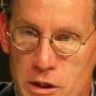

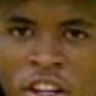

tensor(0)


In [8]:
# define inverse transformations to visualize images from the created dataset
# inspired by https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821
invTrans = v2.Compose([v2.Normalize(mean = [0, 0, 0], std = [1/0.229, 1/0.224, 1/0.225]),
                               v2.Normalize(mean = [-0.485, -0.456, -0.406], std = [1, 1, 1])])

pic = next(iter(dataloaders['val']))
display(v2.functional.to_pil_image(invTrans(pic[0][0]), mode='RGB'))
display(v2.functional.to_pil_image(invTrans(pic[1][0]), mode='RGB'))
print(pic[2][0])

#### 4.

ResNet18 is pre-trained on ImageNet and is computationally sound given our resources (Colab). This is what we'll use for our Siamese Network.

In [15]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision.models import resnet50, ResNet50_Weights

In [16]:
# using GPU/CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

ResNet50 is already very well trained on ImageNet. The final fully connected layer gives a good representation of the image features given the classification task. Now we can directly use this to our advantage by setting some parameters fixed and modifying the rest. After a lot of experimentation including adding further linear layers, setting last one or two convolutional layer blocks among the four in ResNet50 model fixed while the others being trainable, and many such permutations with these and depth of the network and width of the last fully connected layer, I finally obtained the better model among them to be the one in which:

ResNet50's Adaptive Average Pooling and the last fully connected layer is removed. The first convolutional layer block's weights are fixed and are equal to the pre-trained weights. The second convolutional layer block's weights are set as "trainable". Adaptive Average Pooling layer is added after that, and then they are flattened into a dense layer. This is then input to a fully connected linear layer whose final output dimensions are 64. This output is then compared for Cosine Similarity to check if the images are of the same persons or not.

In [17]:
class FaceRecognition(nn.Module):

  def __init__(self):
    super(FaceRecognition, self).__init__()

    # import ResNet18 model with default pretrained weights
    self.backbone = resnet50(weights = ResNet50_Weights.DEFAULT)

    # remove last two layers: adaptive avg pooling and fc
    self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])

    # fix the weights
    for param in self.backbone.parameters():
      param.requires_grad = False

    for param in self.backbone[7].parameters():
      param.requires_grad = True

    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.lin1 = nn.Linear(2048, 512)

  def forward(self, x):

    x = self.backbone(x)
    x = self.avgpool(x)
    x = torch.flatten(x,1)
    x = self.lin1(x)

    return x

In [43]:
FaceRecognition()

FaceRecognition(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Co

#### 6. Training & Validation Setup, and Experimentation on L1 Regularizer

In [23]:
import time
from copy import deepcopy
import matplotlib.pyplot as plt

In [67]:
def train_model(model, criterion, optimizer, scheduler, lambda1 = 0, num_epochs = 25, checkpoint = None):

  since = time.time()
  time_so_far = 0

  best_model_wts = deepcopy(model.state_dict())
  best_acc = 0
  last_epoch = -1

  _loss = {'train': [], 'val': []}
  _acc = {'train': [], 'val': []}

  if checkpoint:
    last_epoch = checkpoint['epoch']
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler'])
    _loss = checkpoint['loss']
    _acc = checkpoint['acc']
    best_acc = checkpoint['best_acc']
    best_model_wts = checkpoint['best_model_wts']
    time_so_far = checkpoint['time_so_far']

  similarity = nn.CosineSimilarity(dim = 1, eps = 1e-6)

  for epoch in range(last_epoch+1, num_epochs):
    if (epoch + 1) % 10 == 0 or epoch == last_epoch+1:
      print(f'\nEpoch {epoch+1}/{num_epochs}')
      print('-' * 10)

    # each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()     # set model to training mode
      else:
        model.eval()      # set model to validation mode

      running_loss = 0
      running_corrects = 0

      # iterate over the data
      for imgs1, imgs2, targets in dataloaders[phase]:
        _imgs1 = imgs1.to(device)
        _imgs2 = imgs2.to(device)
        # targets = 2*targes
        targets = targets.to(device).float()

        # zero the parameter gradients
        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
          out1 = model(_imgs1)
          out2 = model(_imgs2)
          outputs = abs(similarity(out1, out2))
          outputs = torch.clamp(outputs, min=0.0, max=1.0)
          loss = criterion(outputs, targets)

          # L1 regularization, ref #7 and #8 from References
          all_linear_params = torch.cat([p.view(-1) for p in model.lin1.parameters()])
          all_conv_params = torch.cat([p.view(-1) for p in model.backbone[7].parameters()])
          loss += lambda1 * (torch.norm(all_linear_params, 1) + torch.norm(all_conv_params, 1))
          # loss += lambda1 * torch.norm(all_conv_params, 1)

          # backward + optimize only if training
          if phase == 'train':
            loss.backward()
            optimizer.step()

        running_loss += loss.item()*imgs1.size(0)
        # correct classification if abs(target - similarity) <= 0.5
        running_corrects += torch.sum(abs(targets - outputs) <= 0.5)
      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss/dataset_sizes[phase]
      epoch_acc = running_corrects.double()/dataset_sizes[phase]
      if (epoch + 1) % 10 == 0 or epoch == last_epoch+1:
        print(f'{phase} Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')

      _loss[phase].append(epoch_loss)
      _acc[phase].append(epoch_acc)

      time_so_far += time.time() - since

      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = deepcopy(model.state_dict())
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'loss': _loss,
            'acc': _acc,
            'best_acc': best_acc,
            'best_model_wts': best_model_wts,
            'time_so_far': time_so_far
        }, 'checkpoints/best_checkpoint_50_bce_new.pt')

      if phase == 'val':
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'loss': _loss,
            'acc': _acc,
            'best_acc': best_acc,
            'best_model_wts': best_model_wts,
            'time_so_far': time_so_far
        }, 'checkpoints/last_checkpoint_50_bce_new.pt')

  time_elapsed = time.time() - since + time_so_far
  print(f'Training completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Best val accuracy: {best_acc:.4f}')

  # Load best model weights and return
  model.load_state_dict(best_model_wts)
  return model, _loss, _acc

In [69]:
lambda1 = 1e-6
lr = 0.001
Loss = {'train': [], 'val': []}
Acc = {'train': [], 'val': []}

print(f"Training with lambda1 = {lambda1}")
net = FaceRecognition()
net.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr = lr, momentum = 0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.85)
num_epochs = 500

# checkpoint = None
checkpoint = torch.load('checkpoints/last_checkpoint_50_bce.pt', weights_only=False, map_location = 'cpu')

net, Loss, Acc = train_model(net, criterion, optimizer, scheduler, lambda1, num_epochs, checkpoint)

print('='*20)

Training with lambda1 = 1e-06

Epoch 125/500
----------
train Loss: 0.8769, Acc: 0.9451
val Loss: 0.8811, Acc: 0.9297

Epoch 130/500
----------
train Loss: 0.8751, Acc: 0.9467
val Loss: 0.8808, Acc: 0.9297

Epoch 140/500
----------
train Loss: 0.8729, Acc: 0.9483
val Loss: 0.8787, Acc: 0.9299

Epoch 150/500
----------
train Loss: 0.8710, Acc: 0.9495
val Loss: 0.8777, Acc: 0.9304

Epoch 160/500
----------
train Loss: 0.8696, Acc: 0.9503
val Loss: 0.8767, Acc: 0.9291


KeyboardInterrupt: 

In [19]:
checkpoint = torch.load('checkpoints/last_checkpoint_50_bce_new.pt', weights_only=False, map_location = 'cpu')
Acc = checkpoint['acc']
Loss = checkpoint['loss']
epochs = checkpoint['epoch']

In [21]:
# convert from list of tensor floats to list of numpy floats
Acc['train'] = [torch.Tensor.cpu(x).numpy() for x in Acc['train']]
Acc['val'] = [torch.Tensor.cpu(x).numpy() for x in Acc['val']]

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (20, 10))
_epochs = [i+1 for i in range(epochs+1)]

l1 = 1e-6
_lr = 0.001
ax[0].plot(_epochs[10:], Loss['train'][10:], color = 'blue', label = 'Training')
ax[0].plot(_epochs[10:], Loss['val'][10:], color = 'orange', label = 'Validation')
ax[0].set(xlabel = 'Epoch', ylabel = 'Error')
ax[0].set_title(r'Loss vs Epoch for $\lambda_1$ = ' + str(l1) + ' and lr = ' + str(_lr))
ax[0].legend()

ax[1].plot(_epochs, Acc['train'], color = 'blue', label = 'Training')
ax[1].plot(_epochs, Acc['val'], color = 'orange', label = 'Validation')
ax[1].set(xlabel = 'Epoch', ylabel = 'Accuracy')
ax[1].set_title(r'Accuracy vs Epoch for $\lambda_1$ = ' + str(l1) + ' and lr = ' + str(_lr))
ax[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
lambda1 = 4e-4
lr = 0.006
lr_stepsize = [1, 4, 8, 12, 16]
Loss = {'train': [], 'val': []}
Acc = {'train': [], 'val': []}

for lr_step in lr_stepsize:
  print(f"Training with Learning Rate Scheduler step size = {lr_step}")
  net = FaceRecognition()
  net.to(device)
  criterion = nn.BCEWithLogitsLoss()
  optimizer = optim.SGD(net.parameters(), lr = lr, momentum = 0.9)
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = lr_step, gamma = 0.8)
  num_epochs = 25

  net, _loss, _acc = train_model(net, criterion, optimizer, scheduler, lambda1, num_epochs)

  for phase in ['train', 'val']:
    Loss[phase].append(_loss[phase])
    Acc[phase].append(_acc[phase])

print('='*20)

Training with Learning Rate Scheduler step size = 1

Epoch 1/25
----------
train Loss: 6.0936, Acc: 0.5199
val Loss: 5.8593, Acc: 0.5839

Epoch 25/25
----------
train Loss: 4.8125, Acc: 0.6645
val Loss: 4.8201, Acc: 0.6383
Training completed in 2m 1s
Best val accuracy: 0.6423
Training with Learning Rate Scheduler step size = 4

Epoch 1/25
----------
train Loss: 6.0928, Acc: 0.5193
val Loss: 5.8579, Acc: 0.5738

Epoch 25/25
----------
train Loss: 3.0015, Acc: 0.7662
val Loss: 3.0054, Acc: 0.7342
Training completed in 1m 58s
Best val accuracy: 0.7342
Training with Learning Rate Scheduler step size = 8

Epoch 1/25
----------
train Loss: 6.0956, Acc: 0.5153
val Loss: 5.8578, Acc: 0.5758

Epoch 25/25
----------
train Loss: 2.4403, Acc: 0.7927
val Loss: 2.4354, Acc: 0.7174
Training completed in 1m 58s
Best val accuracy: 0.7221
Training with Learning Rate Scheduler step size = 12

Epoch 1/25
----------
train Loss: 6.1287, Acc: 0.4811
val Loss: 5.9350, Acc: 0.4960

Epoch 25/25
----------
train

In [ ]:
# convert from list of tensor floats to list of numpy floats
for i in range(5):
  Acc['train'][i] = [torch.Tensor.cpu(x).numpy() for x in Acc['train'][i]]
  Acc['val'][i] = [torch.Tensor.cpu(x).numpy() for x in Acc['val'][i]]

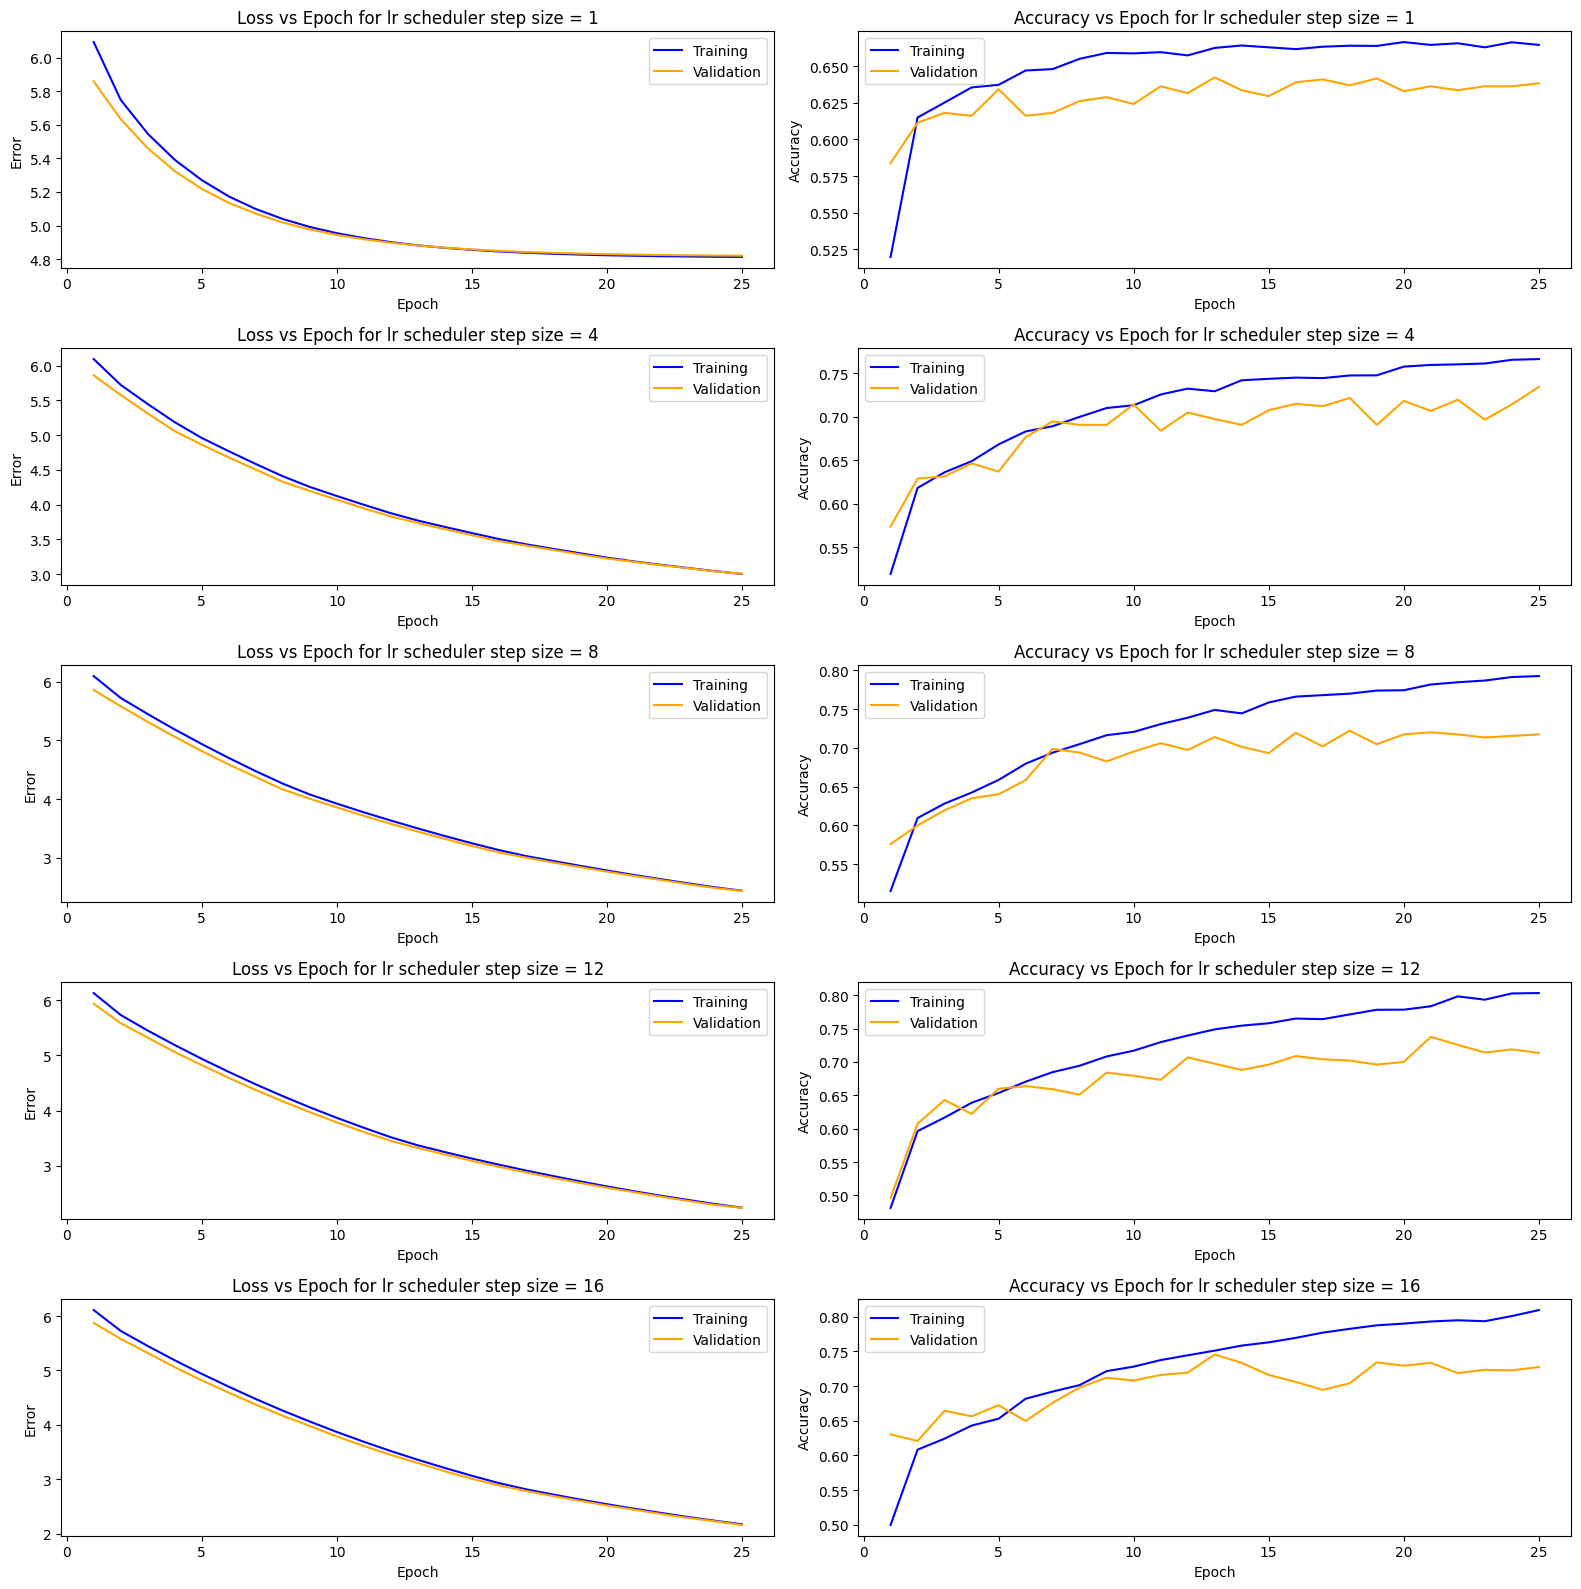

In [ ]:
fig, ax = plt.subplots(5, 2, figsize = (16, 16))
_epochs = [i+1 for i in range(25)]
for i in range(5):
  lr_step = lr_stepsize[i]
  ax[i][0].plot(_epochs, Loss['train'][i], color = 'blue', label = 'Training')
  ax[i][0].plot(_epochs, Loss['val'][i], color = 'orange', label = 'Validation')
  ax[i][0].set(xlabel = 'Epoch', ylabel = 'Error')
  ax[i][0].set_title('Loss vs Epoch for lr scheduler step size = ' + str(lr_step))
  ax[i][0].legend()

  ax[i][1].plot(_epochs, Acc['train'][i], color = 'blue', label = 'Training')
  ax[i][1].plot(_epochs, Acc['val'][i], color = 'orange', label = 'Validation')
  ax[i][1].set(xlabel = 'Epoch', ylabel = 'Accuracy')
  ax[i][1].set_title('Accuracy vs Epoch for lr scheduler step size = ' + str(lr_step))
  ax[i][1].legend()

plt.tight_layout()
plt.show()

From the above plots, we can observe that with a very low scheduler step, the algorithm doesn't converge to a lower loss, because the gradient step keeps getting diminished way too fast and thus, not enough descent takes place with each epoch. Whereas with higher scheduler step, the loss does go down, but not too significant compared to the slightly lower steps. But when we look at the accuracy, we see that there's a rather drastic oscillation in the higher scheduler steps compared to lower. This is because the learning rate doesn't decay fast enough. So, close to the opima, the learning rate is a bit more than required and the gradient instead of just descending, it shoots off to the other side of the local optimum, and this leads to oscillations. Although, this is not so evident in the training loss or accuracy, probably because of the fact that my learning rate is already a bit low enough that the curves appear to be smooth even at higher scheduler steps. But we do see that with the validation accuracy, the oscillations are more pronounced, this might add to lesser generalizability of the model at those parameters.

In [ ]:
lambda1 = 4e-4
lr = 0.006
Loss = {'train': [], 'val': []}
Acc = {'train': [], 'val': []}

criterion = nn.BCEWithLogitsLoss()
num_epochs = 30

Training with SGD optimizer

In [ ]:
print(f"Training with SGD Optimizer")
net = FaceRecognition()
net.to(device)
optimizer = optim.SGD(net.parameters(), lr = lr, momentum = 0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 8, gamma = 0.9)

net, _loss, _acc = train_model(net, criterion, optimizer, scheduler, lambda1, num_epochs)

for phase in ['train', 'val']:
  Loss[phase].append(_loss[phase])
  Acc[phase].append(_acc[phase])

Training with SGD Optimizer

Epoch 1/30
----------
train Loss: 6.0886, Acc: 0.5159
val Loss: 5.8606, Acc: 0.5899

Epoch 10/30
----------
train Loss: 3.8934, Acc: 0.7350
val Loss: 3.8226, Acc: 0.6953

Epoch 20/30
----------
train Loss: 2.6243, Acc: 0.7911
val Loss: 2.5998, Acc: 0.7188

Epoch 30/30
----------
train Loss: 1.9526, Acc: 0.8312
val Loss: 1.9562, Acc: 0.7168
Training completed in 2m 23s
Best val accuracy: 0.7423


Training with Adam Optimizer

In [ ]:
print(f"Training with Adam Optimizer")
net = FaceRecognition()
net.to(device)
optimizer = optim.Adam(net.parameters(), lr = lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 8, gamma = 0.9)

net, _loss, _acc = train_model(net, criterion, optimizer, scheduler, lambda1, num_epochs)

for phase in ['train', 'val']:
  Loss[phase].append(_loss[phase])
  Acc[phase].append(_acc[phase])

Training with Adam Optimizer

Epoch 1/30
----------
train Loss: 1.9602, Acc: 0.5515
val Loss: 1.4139, Acc: 0.4940

Epoch 10/30
----------
train Loss: 0.8361, Acc: 0.6848
val Loss: 0.8818, Acc: 0.5919

Epoch 20/30
----------
train Loss: 0.8135, Acc: 0.7013
val Loss: 0.8392, Acc: 0.6315

Epoch 30/30
----------
train Loss: 0.8043, Acc: 0.7006
val Loss: 0.8210, Acc: 0.6651
Training completed in 2m 21s
Best val accuracy: 0.6758


In [ ]:
# convert from list of tensor floats to list of numpy floats
for i in range(2):
  Acc['train'][i] = [torch.Tensor.cpu(x).numpy() for x in Acc['train'][i]]
  Acc['val'][i] = [torch.Tensor.cpu(x).numpy() for x in Acc['val'][i]]

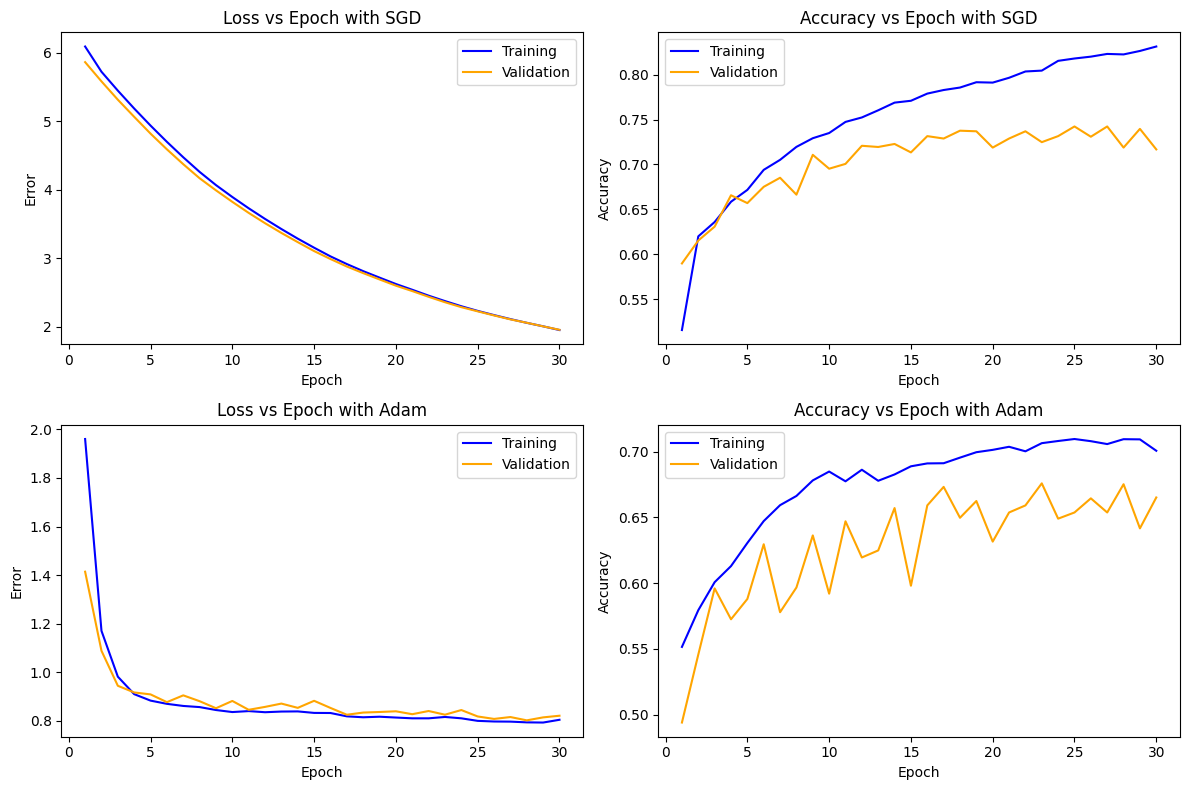

In [ ]:
fig, ax = plt.subplots(2, 2, figsize = (12, 8))
_epochs = [i+1 for i in range(30)]
_optim = ['SGD', 'Adam']
for i in range(2):
  ax[i][0].plot(_epochs, Loss['train'][i], color = 'blue', label = 'Training')
  ax[i][0].plot(_epochs, Loss['val'][i], color = 'orange', label = 'Validation')
  ax[i][0].set(xlabel = 'Epoch', ylabel = 'Error')
  ax[i][0].set_title('Loss vs Epoch with ' + _optim[i])
  ax[i][0].legend()

  ax[i][1].plot(_epochs, Acc['train'][i], color = 'blue', label = 'Training')
  ax[i][1].plot(_epochs, Acc['val'][i], color = 'orange', label = 'Validation')
  ax[i][1].set(xlabel = 'Epoch', ylabel = 'Accuracy')
  ax[i][1].set_title('Accuracy vs Epoch with ' + _optim[i])
  ax[i][1].legend()

plt.tight_layout()
plt.show()

SGD works better when it comes to generalization. That is probably because when it performs gradient descent, it computes the gradient over the loss of individual samples randomly rather than on the whole batch. And since it might not always come back to the same datapoint, it helps generalize the model better. But when it comes to convergence, SGD is slower compared to Adam. This is because of the momentum term in the Adam optimizer's gradient descent algorithm. The momentum term helps better estimate the leap over the gradient that should be taken by taking into account second order terms, and thus reducing the convergence time. In our case, the epochs aren't too many, so, SGD works better since we want good generalization too.

#### 9. Evaluation of the model on Test Data

In [51]:
# load the trained model
checkpoint = torch.load('checkpoints/last_checkpoint_50_bce_new.pt', weights_only=False, map_location = 'cpu')
net = FaceRecognition()
net.to(device)
net.load_state_dict(checkpoint['best_model_wts'])

<All keys matched successfully>

In [53]:
checkpoint['best_acc']

tensor(0.9415, dtype=torch.float64)

In [26]:
def test_model(model):

  model.eval()
  similarity = nn.CosineSimilarity(dim = 1, eps = 1e-6)

  running_corrects = 0

  # iterate over the data
  for imgs1, imgs2, targets in dataloaders['test']:
    imgs1 = imgs1.to(device)
    imgs2 = imgs2.to(device)
    targets = targets.to(device).float()

    out1 = model(imgs1)
    out2 = model(imgs2)
    outputs = abs(similarity(out1, out2))

    # correct classification if abs(target - similarity) <= 0.5
    running_corrects += torch.sum(abs(targets - outputs) <= 0.5)

  test_acc = running_corrects.double()/dataset_sizes['test']

  print(f'The accuracy on test data is {test_acc*100:.2f}%')

In [55]:
# call the test_model function with 'net' as the input
# 'net' is the best model obtained while training the model prior to this
test_model(net)

The accuracy on test data is 80.79%


In [ ]:
# load images
imgs = []
imgs.append('faces/dad00.jpeg')
imgs.append('faces/dad01.jpeg')
imgs.append('faces/me00.jpeg')
imgs.append('faces/mahesh00.jpeg')
imgs.append('faces/mahesh01.jpeg')
imgs.append('faces/shashank00.jpeg')

In [ ]:
# resize the images
for img in imgs:
  img1 = Image.open(img)
  img1 = img1.resize((250,250))
  img1.save(img)

In [ ]:
imgs_cropped = []
imgs_transformed = []

for img in imgs:
  img1 = get_cropped_image(img)
  imgs_cropped.append(img1)
  img2 = data_transforms['test'](img1)
  imgs_transformed.append(img2)

In [ ]:
net.eval()
similarity = nn.CosineSimilarity(dim = 1, eps = 1e-6)

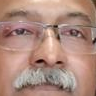

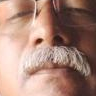

As per the model, the above two persons are the same


In [ ]:
img1 = imgs_transformed[0]  # dad's image 1
img2 = imgs_transformed[1]  # dad's image 2

# the unsqueeze here adds a batch dimension of 1 to the image,
# which is necessary when feeding it to the network
img1 = img1.to(device).unsqueeze(0)
img2 = img2.to(device).unsqueeze(0)

out1 = net(img1)
out2 = net(img2)
output = abs(similarity(out1, out2))

same = 'the same' if output >= 0.5 else 'not the same'

display(imgs_cropped[0])
display(imgs_cropped[1])
print(f'As per the model, the above two persons are {same}')

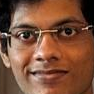

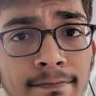

As per the model, the above two persons are the same


In [ ]:
img1 = imgs_transformed[2]  # my image
img2 = imgs_transformed[3]  # my friend Mahesh's image 1

# the unsqueeze here adds a batch dimension of 1 to the image,
# which is necessary when feeding it to the network
img1 = img1.to(device).unsqueeze(0)
img2 = img2.to(device).unsqueeze(0)

out1 = net(img1)
out2 = net(img2)
output = abs(similarity(out1, out2))

same = 'the same' if output >= 0.5 else 'not the same'

display(imgs_cropped[2])
display(imgs_cropped[3])
print(f'As per the model, the above two persons are {same}')

Clearly it went wrong on the above one xD

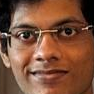

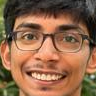

As per the model, the above two persons are the same


In [ ]:
img1 = imgs_transformed[2]  # my image
img2 = imgs_transformed[4]  # my friend Mahesh's image 2

# the unsqueeze here adds a batch dimension of 1 to the image,
# which is necessary when feeding it to the network
img1 = img1.to(device).unsqueeze(0)
img2 = img2.to(device).unsqueeze(0)

out1 = net(img1)
out2 = net(img2)
output = abs(similarity(out1, out2))

same = 'the same' if output >= 0.5 else 'not the same'

display(imgs_cropped[2])
display(imgs_cropped[4])
print(f'As per the model, the above two persons are {same}')

Maybe my friend and I do look quite similar xD

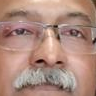

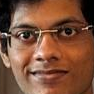

As per the model, the above two persons are not the same


In [ ]:
img1 = imgs_transformed[0]  # dad's image 1
img2 = imgs_transformed[2]  # my image

# the unsqueeze here adds a batch dimension of 1 to the image,
# which is necessary when feeding it to the network
img1 = img1.to(device).unsqueeze(0)
img2 = img2.to(device).unsqueeze(0)

out1 = net(img1)
out2 = net(img2)
output = abs(similarity(out1, out2))

same = 'the same' if output >= 0.5 else 'not the same'

display(imgs_cropped[0])
display(imgs_cropped[2])
print(f'As per the model, the above two persons are {same}')

Good, can differentiate between me and my dad

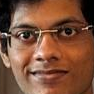

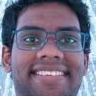

As per the model, the above two persons are not the same


In [ ]:
img1 = imgs_transformed[2]  # my image
img2 = imgs_transformed[5]  # my friend Shashank's image

# the unsqueeze here adds a batch dimension of 1 to the image,
# which is necessary when feeding it to the network
img1 = img1.to(device).unsqueeze(0)
img2 = img2.to(device).unsqueeze(0)

out1 = net(img1)
out2 = net(img2)
output = abs(similarity(out1, out2))

same = 'the same' if output >= 0.5 else 'not the same'

display(imgs_cropped[2])
display(imgs_cropped[5])
print(f'As per the model, the above two persons are {same}')

### **Part B**

### 11.

### References

Resources referred to but not explicitly mentioned in code blocks itself:

1. PyTorch Documentation
2. Numpy Documentation
3. https://stackoverflow.com/questions/47403634/transfer-learning-resnet18-using-pytorch-dataset-dog-breed-identification
4. https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/
5. https://pytorch.org/vision/main/_modules/torchvision/datasets/folder.html
6. https://stackoverflow.com/questions/53803889/siamese-neural-network-in-pytorch
7. https://discuss.pytorch.org/t/how-to-add-a-l2-regularization-term-in-my-loss-function/17411/17
8. https://stackoverflow.com/questions/44641976/pytorch-how-to-add-l1-regularizer-to-activations
9. https://github.com/taki0112/BigGAN-Tensorflow/issues/3
10. https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py
11. https://discuss.pytorch.org/t/possible-to-extend-a-pre-trained-model/125497/5
12. https://discuss.pytorch.org/t/adding-layers-to-transfer-learnig/98101/3